Install packages

In [4]:
!pip install transformers torch pandas matplotlib tqdm numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

Import libraries and setup

In [5]:
import os
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import zipfile
from tqdm import tqdm
import numpy as np
from datetime import datetime
from google.colab import files as colab_files
from google.colab import drive

print(datetime.now())
print("✅ Environment ready.")

2025-06-24 09:46:58.655882
✅ Environment ready.


Upload files directly to Colab (alternative to Drive)

In [6]:
print("Upload your CSV files or ZIP folders:")
uploaded = colab_files.upload()



Upload your CSV files or ZIP folders:


Saving cluster_files.zip to cluster_files.zip


Create directory for uploaded files

In [7]:
os.makedirs('/content/data', exist_ok=True)

for filename in uploaded.keys():
    file_path = f'/content/{filename}'

    # Check if it's a ZIP file
    if filename.lower().endswith('.zip'):
        print(f"📦 Extracting ZIP file: {filename}")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall('/content/data')
        os.remove(file_path)  # Remove the ZIP file after extraction
        print(f"✅ Extracted: {filename}")
    else:
        # Move regular files to data directory
        os.rename(file_path, f'/content/data/{filename}')
        print(f"✅ Uploaded: {filename}")

# Show what we have in the data directory
print("\n📁 Contents of /content/data:")
for root, dirs, files in os.walk('/content/data'):
    level = root.replace('/content/data', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f"{subindent}{file}")

📦 Extracting ZIP file: cluster_files.zip
✅ Extracted: cluster_files.zip

📁 Contents of /content/data:
data/
  cluster_files/
    feminism_clustered_texts_after.csv
    MensRights_clustered_after.csv
    feminsim_clustered_texts_before.csv
    LGBT_clustered_after.csv
    LGBT_clustered_before.csv
    MensRights_clustered_before.csv


Load sentiment analysis model

In [8]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
print("🔄 Loading tokenizer and model...")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
tokenizer.model_max_length = 512
model = AutoModelForSequenceClassification.from_pretrained(model_name)

id2label = {0: "Negative", 1: "Neutral", 2: "Positive"}
labels = [id2label[i] for i in range(len(id2label))]


🔄 Loading tokenizer and model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

use GPU if available on Colab

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("🔍 CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🖥️ Using GPU:", torch.cuda.get_device_name(0))
else:
    print("⚠️ Running on CPU")


🔍 CUDA Available: True
🖥️ Using GPU: NVIDIA L4


Define helper functions

In [10]:
def find_csv_files(root_dir="/content/data"):
    """Find CSV files in the specified directory and all subdirectories"""
    csv_files, file_paths = [], []

    print(f"🔍 Searching for CSV files in: {root_dir}")

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.csv') and '_with_sentiment' not in file:
                csv_files.append(file)
                file_paths.append(os.path.join(root, file))
                print(f"  Found: {file} in {root}")

    if not csv_files:
        print("❌ No CSV files found!")
        print("📁 Current directory structure:")
        for root, dirs, files in os.walk(root_dir):
            level = root.replace(root_dir, '').count(os.sep)
            indent = ' ' * 2 * level
            print(f"{indent}{os.path.basename(root)}/")
            subindent = ' ' * 2 * (level + 1)
            for file in files[:5]:  # Show first 5 files
                print(f"{subindent}{file}")
            if len(files) > 5:
                print(f"{subindent}... and {len(files) - 5} more files")

    return csv_files, file_paths, root_dir

def classify_batch(texts, batch_size=16):
    """Classify sentiment for a batch of texts"""
    all_sentiments, all_confidences, all_top_labels, all_scores = [], [], [], []

    for i in tqdm(range(0, len(texts), batch_size), desc="Processing batches"):
        batch_texts = texts[i:i+batch_size]
        processed_texts = ["No content" if pd.isna(t) or str(t).strip() == "" else str(t)[:2000] for t in batch_texts]

        encoded = tokenizer(processed_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        encoded = {k: v.to(device) for k, v in encoded.items()}

        with torch.no_grad():
            outputs = model(**encoded)
            scores = torch.nn.functional.softmax(outputs.logits, dim=1)

        for score in scores:
            idx = torch.argmax(score).item()
            label = labels[idx]
            confidence = score[idx].item()
            final_sentiment = "Uncertain" if confidence < 0.6 else label

            all_sentiments.append(final_sentiment)
            all_confidences.append(confidence)
            all_top_labels.append(label)
            all_scores.append({
                'negative_score': score[0].item(),
                'neutral_score': score[1].item(),
                'positive_score': score[2].item()
            })

    return all_sentiments, all_confidences, all_top_labels, all_scores

def plot_cluster_sentiment_comparison(cluster_df, filename, output_dir="/content/results"):
    """Create sentiment distribution plots by cluster"""
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(15, 8))
    clusters = cluster_df['cluster_name']
    bottom_neutral = cluster_df['negative_pct']
    bottom_positive = cluster_df['negative_pct'] + cluster_df['neutral_pct']
    bottom_uncertain = cluster_df['negative_pct'] + cluster_df['neutral_pct'] + cluster_df['positive_pct']

    plt.bar(clusters, cluster_df['negative_pct'], label='Negative', color='#ff6b6b', alpha=0.8)
    plt.bar(clusters, cluster_df['neutral_pct'], bottom=bottom_neutral, label='Neutral', color='#ffd93d', alpha=0.8)
    plt.bar(clusters, cluster_df['positive_pct'], bottom=bottom_positive, label='Positive', color='#6bcf7f', alpha=0.8)
    plt.bar(clusters, cluster_df['uncertain_pct'], bottom=bottom_uncertain, label='Uncertain', color='#a8a8a8', alpha=0.8)

    # Title mapping
    title_map = {
        "mensrights_clustered_before.csv": "Sentiment Distribution by Cluster in r/MensRights Pre-Election",
        "mensrights_clustered_after.csv": "Sentiment Distribution by Cluster in r/MensRights Post-Election",
        "feminism_clustered_before.csv": "Sentiment Distribution by Cluster in r/Feminism Pre-Election",
        "feminism_clustered_after.csv": "Sentiment Distribution by Cluster in r/Feminism Post-Election",
        "lgbt_clustered_before.csv": "Sentiment Distribution by Cluster in r/LGBT Pre-Election",
        "lgbt_clustered_after.csv": "Sentiment Distribution by Cluster in r/LGBT Post-Election"
    }

    plot_title = title_map.get(filename.lower(), f"Sentiment Distribution by Cluster\n{filename}")
    plt.title(plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Clusters')
    plt.ylabel('Percentage of Posts')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(output_dir, filename.replace(".csv", "_cluster_sentiment_distribution.png"))
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display in Colab
    plt.close()
    print(f"📊 Saved cluster sentiment distribution: {plot_path}")

Main processing function

In [11]:
def process_files():
    """Process all CSV files for sentiment analysis"""
    csv_files, csv_file_paths, input_folder = find_csv_files()
    output_folder = "/content/results"
    os.makedirs(output_folder, exist_ok=True)

    if not csv_files:
        print("❌ No CSV files found to process!")
        print("\n🔧 Troubleshooting steps:")
        print("1. Make sure you uploaded CSV files or a ZIP containing CSV files")
        print("2. Check that CSV files don't have '_with_sentiment' in their names")
        print("3. Verify file extensions are .csv (case sensitive)")
        return

    print(f"📂 Found {len(csv_files)} CSV files:")
    for i, (filename, filepath) in enumerate(zip(csv_files, csv_file_paths)):
        print(f"  {i+1}. {filename} → {filepath}")

    required_cols = ['text', 'cluster', 'cluster_name', 'source']

    for filename, file_path in zip(csv_files, csv_file_paths):
        print(f"\n🔄 Processing: {filename}")
        try:
            df = pd.read_csv(file_path)
            print(f"📊 Loaded {len(df)} rows from {filename}")

            # Show available columns
            print(f"📋 Available columns: {list(df.columns)}")

            # Check for required columns (be more flexible)
            missing = [col for col in required_cols if col not in df.columns]
            if missing:
                print(f"⚠️ Missing columns in {filename}: {missing}")

                # Try to find text column with different names
                text_col = None
                for col in df.columns:
                    if 'text' in col.lower() or 'content' in col.lower() or 'body' in col.lower():
                        text_col = col
                        break

                if text_col:
                    print(f"✅ Found text column: '{text_col}', using it instead of 'text'")
                    df = df.rename(columns={text_col: 'text'})
                else:
                    print(f"❌ No text column found. Available columns: {list(df.columns)}")
                    continue

            # Process sentiment analysis
            texts = df['text'].tolist()
            print(f"📊 Analyzing sentiment for {len(texts)} texts...")

            sentiments, confidences, top_labels, raw_scores = classify_batch(texts)

            # Add results to dataframe
            df['sentiment'] = sentiments
            df['confidence'] = confidences
            df['raw_prediction'] = top_labels

            # Add individual sentiment scores
            scores_df = pd.DataFrame(raw_scores)
            df = pd.concat([df, scores_df], axis=1)

            # Save results
            output_path = os.path.join(output_folder, filename.replace(".csv", "_with_sentiment.csv"))
            df.to_csv(output_path, index=False)
            print(f"💾 Saved individual results: {output_path}")

            # Display sample results
            print(f"📋 Sample results from {filename}:")
            sample_df = df[['text', 'sentiment', 'confidence']].head()
            for idx, row in sample_df.iterrows():
                text_preview = str(row['text'])[:100] + "..." if len(str(row['text'])) > 100 else str(row['text'])
                print(f"  Text: {text_preview}")
                print(f"  Sentiment: {row['sentiment']} (confidence: {row['confidence']:.3f})")
                print()

        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")
            import traceback
            traceback.print_exc()


Run analysis

In [12]:
if __name__ == "__main__":
    process_files()
    print("\n🎉 All files processed successfully!")


🔍 Searching for CSV files in: /content/data
  Found: feminism_clustered_texts_after.csv in /content/data/cluster_files
  Found: MensRights_clustered_after.csv in /content/data/cluster_files
  Found: feminsim_clustered_texts_before.csv in /content/data/cluster_files
  Found: LGBT_clustered_after.csv in /content/data/cluster_files
  Found: LGBT_clustered_before.csv in /content/data/cluster_files
  Found: MensRights_clustered_before.csv in /content/data/cluster_files
📂 Found 6 CSV files:
  1. feminism_clustered_texts_after.csv → /content/data/cluster_files/feminism_clustered_texts_after.csv
  2. MensRights_clustered_after.csv → /content/data/cluster_files/MensRights_clustered_after.csv
  3. feminsim_clustered_texts_before.csv → /content/data/cluster_files/feminsim_clustered_texts_before.csv
  4. LGBT_clustered_after.csv → /content/data/cluster_files/LGBT_clustered_after.csv
  5. LGBT_clustered_before.csv → /content/data/cluster_files/LGBT_clustered_before.csv
  6. MensRights_clustered_bef

Processing batches: 100%|██████████| 148/148 [00:23<00:00,  6.37it/s]


💾 Saved individual results: /content/results/feminism_clustered_texts_after_with_sentiment.csv
📋 Sample results from feminism_clustered_texts_after.csv:
  Text: hello peeps anyone else feels really alone as a feminist this feeling might vary greatly based on yo...
  Sentiment: Uncertain (confidence: 0.520)

  Text: hello my son a high student said his gym teacher told the boys during a demonstration don t throw li...
  Sentiment: Negative (confidence: 0.890)

  Text: as of november 2024 the following states and the district of columbia allow same day voter registrat...
  Sentiment: Neutral (confidence: 0.892)

  Text: i can t get used to it will never get used to it
  Sentiment: Negative (confidence: 0.846)

  Text: i keep seeing books where the moral is where girls should tolerate boys but not vice versa i d like ...
  Sentiment: Neutral (confidence: 0.715)


🔄 Processing: MensRights_clustered_after.csv
📊 Loaded 2703 rows from MensRights_clustered_after.csv
📋 Available columns: ['text

Processing batches: 100%|██████████| 169/169 [00:27<00:00,  6.21it/s]


💾 Saved individual results: /content/results/MensRights_clustered_after_with_sentiment.csv
📋 Sample results from MensRights_clustered_after.csv:
  Text: saw this book at my bookstore job today and was furious when i read the back of it the premise basic...
  Sentiment: Negative (confidence: 0.966)

  Text: hopefully this belongs here i got banned from another subreddit because the mods thought my post was...
  Sentiment: Negative (confidence: 0.610)

  Text: over the years i ve sunk a lot of time into reading feminist research and there s one thing i ve con...
  Sentiment: Uncertain (confidence: 0.514)

  Text: as a female this is a genuine question that i ve had thank you have a good night
  Sentiment: Positive (confidence: 0.896)

  Text: found this interesting article with an interview with co owner of epicentr group largest household a...
  Sentiment: Negative (confidence: 0.728)


🔄 Processing: feminsim_clustered_texts_before.csv
📊 Loaded 1158 rows from feminsim_clustered_texts_be

Processing batches: 100%|██████████| 73/73 [00:12<00:00,  6.06it/s]


💾 Saved individual results: /content/results/feminsim_clustered_texts_before_with_sentiment.csv
📋 Sample results from feminsim_clustered_texts_before.csv:
  Text: it was a video of a man biologist explaining how and why sa should be considered the biggest crime a...
  Sentiment: Uncertain (confidence: 0.466)

  Text: i have a gut feeling that in the future the fourth reich will take place and very soon the fourth re...
  Sentiment: Negative (confidence: 0.885)

  Text: l
  Sentiment: Uncertain (confidence: 0.495)

  Text: so my partner and me where discussing going to an event together tomorrow evening i said i wasn t su...
  Sentiment: Uncertain (confidence: 0.572)

  Text: nívea new ad for skincare for men has a football player confidently announcing skin care we ve got b...
  Sentiment: Negative (confidence: 0.601)


🔄 Processing: LGBT_clustered_after.csv
📊 Loaded 18064 rows from LGBT_clustered_after.csv
📋 Available columns: ['text', 'cluster', 'cluster_name', 'source']
📊 Analyzing 

Processing batches: 100%|██████████| 1129/1129 [03:05<00:00,  6.09it/s]


💾 Saved individual results: /content/results/LGBT_clustered_after_with_sentiment.csv
📋 Sample results from LGBT_clustered_after.csv:
  Text: hi i m a teenage girl and i have literally no clue what sexuality i am i did so much gay stuff when ...
  Sentiment: Uncertain (confidence: 0.480)

  Text: i usually post in r translater but haunt this sub wanted to share a pic before the election 46yo tra...
  Sentiment: Positive (confidence: 0.882)

  Text: i m not in the wrong having a past is not being delusional a past is things that actually happened b...
  Sentiment: Neutral (confidence: 0.722)

  Text: why does everyone i come across to get help wants to have sex in order to help me i ve been homeless...
  Sentiment: Negative (confidence: 0.826)

  Text: what s it called when you re attracted to men and woman but you would only have sex with a woman and...
  Sentiment: Neutral (confidence: 0.622)


🔄 Processing: LGBT_clustered_before.csv
📊 Loaded 20161 rows from LGBT_clustered_before.csv
📋

Processing batches: 100%|██████████| 1261/1261 [03:25<00:00,  6.14it/s]


💾 Saved individual results: /content/results/LGBT_clustered_before_with_sentiment.csv
📋 Sample results from LGBT_clustered_before.csv:
  Text: can anyone give any recommendations for good places or online stores to get binders in the uk i can ...
  Sentiment: Neutral (confidence: 0.659)

  Text: i openly identified as non binary for a while but gave up because no one cared i now spiritually ide...
  Sentiment: Negative (confidence: 0.856)

  Text: i 14 male him 15 i need tips for asking him out and how to tell if he s gay btw we sung at the end o...
  Sentiment: Neutral (confidence: 0.790)

  Text: there are queer platonic i actually hate some of the discourse around this there s a lot of implying...
  Sentiment: Negative (confidence: 0.910)

  Text: so basically i ve been best friends with this girl since 9th grade i am now currently 10th we ve spe...
  Sentiment: Neutral (confidence: 0.626)


🔄 Processing: MensRights_clustered_before.csv
📊 Loaded 2420 rows from MensRights_clustered_b

Processing batches: 100%|██████████| 152/152 [00:24<00:00,  6.14it/s]

💾 Saved individual results: /content/results/MensRights_clustered_before_with_sentiment.csv
📋 Sample results from MensRights_clustered_before.csv:
  Text: i m from a decent sized city and i used to think men not trusting women was a bit unfounded unreason...
  Sentiment: Negative (confidence: 0.788)

  Text: hey everyone sorry to put this post here but i was wondering if anyone from mid wales was thinking a...
  Sentiment: Neutral (confidence: 0.630)

  Text: a very good friend of mine who is almost like a brother to me was recently diagnosed with stage 3 th...
  Sentiment: Uncertain (confidence: 0.510)

  Text: not the first time i ve ranted about this but it s really infuriating and tiresome to see so many ig...
  Sentiment: Negative (confidence: 0.915)

  Text: social status in men is sexy men s social status accounts for 62 of the variance in the opportunity ...
  Sentiment: Uncertain (confidence: 0.560)


🎉 All files processed successfully!


Downloas results

In [13]:
print("📥 Download processed files:")
# List all result files
result_files = [f for f in os.listdir('/content/results') if f.endswith('.csv') or f.endswith('.png')]
for file in result_files:
    colab_files.download(f'/content/results/{file}')
    print(f"Downloaded: {file}")

📥 Download processed files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: MensRights_clustered_after_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: LGBT_clustered_before_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: feminsim_clustered_texts_before_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: feminism_clustered_texts_after_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: LGBT_clustered_after_with_sentiment.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: MensRights_clustered_before_with_sentiment.csv


Display file structure for debugging

In [14]:
print("📁 Current file structure:")
for root, dirs, files in os.walk('/content'):
    level = root.replace('/content', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for file in files[:10]:  # Show first 10 files only
        print(f"{subindent}{file}")
    if len(files) > 10:
        print(f"{subindent}... and {len(files) - 10} more files")

📁 Current file structure:
content/
  .config/
    gce
    .last_survey_prompt.yaml
    .last_update_check.json
    active_config
    .last_opt_in_prompt.yaml
    config_sentinel
    hidden_gcloud_config_universe_descriptor_data_cache_configs.db
    default_configs.db
    logs/
      2025.06.20/
        13.37.50.274592.log
        13.37.39.370876.log
        13.37.06.815112.log
        13.37.49.523438.log
        13.37.37.819145.log
        13.37.28.379622.log
    configurations/
      config_default
  results/
    MensRights_clustered_after_with_sentiment.csv
    LGBT_clustered_before_with_sentiment.csv
    feminsim_clustered_texts_before_with_sentiment.csv
    feminism_clustered_texts_after_with_sentiment.csv
    LGBT_clustered_after_with_sentiment.csv
    MensRights_clustered_before_with_sentiment.csv
  data/
    cluster_files/
      feminism_clustered_texts_after.csv
      MensRights_clustered_after.csv
      feminsim_clustered_texts_before.csv
      LGBT_clustered_after.csv
      L

Generate visualizations plots

📊 Generating visualizations for 6 files...

🎨 Creating plot for: MensRights_clustered_after_with_sentiment.csv
📋 Cluster summary for MensRights_clustered_after_with_sentiment.csv:
  Masculinity & Identity: 597 posts
    Neg: 61.6%, Neu: 8.5%, Pos: 1.2%, Unc: 28.6%
  Personal Reflections & Emotions: 374 posts
    Neg: 56.7%, Neu: 5.6%, Pos: 4.3%, Unc: 33.4%
  Gender Issues & Male Victimhood: 965 posts
    Neg: 40.6%, Neu: 20.6%, Pos: 6.3%, Unc: 32.4%
  Gender & Social Roles: 487 posts
    Neg: 62.0%, Neu: 8.4%, Pos: 2.7%, Unc: 26.9%
  Media & Link Embeds: 47 posts
    Neg: 27.7%, Neu: 48.9%, Pos: 4.3%, Unc: 19.1%
  External Content & News Links: 233 posts
    Neg: 33.0%, Neu: 33.5%, Pos: 7.7%, Unc: 25.8%


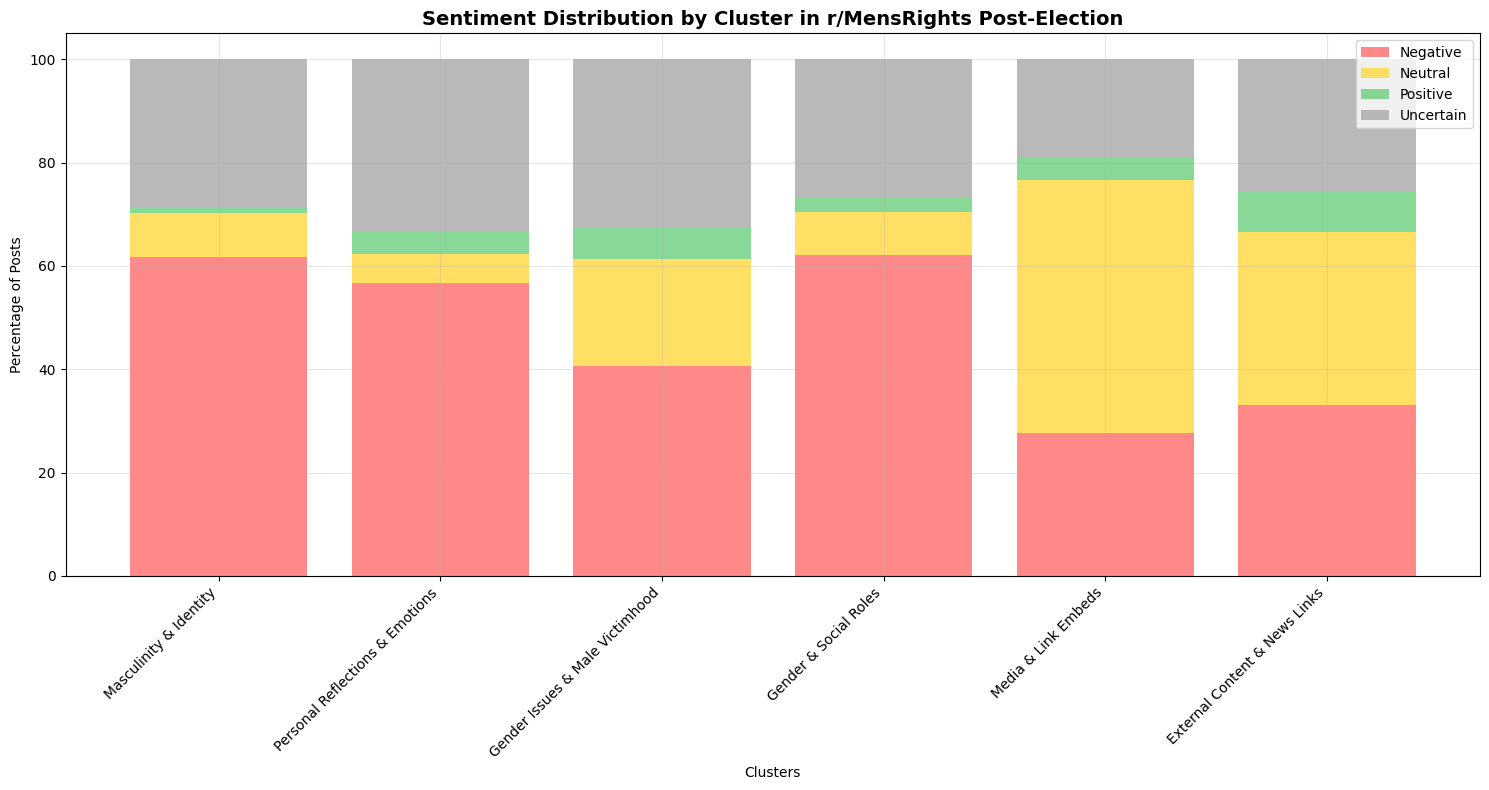

📊 Saved cluster sentiment distribution: /content/results/MensRights_clustered_after_cluster_sentiment_distribution.png

🎨 Creating plot for: LGBT_clustered_before_with_sentiment.csv
📋 Cluster summary for LGBT_clustered_before_with_sentiment.csv:
  Community & Pride Narratives: 9707 posts
    Neg: 24.7%, Neu: 25.2%, Pos: 19.9%, Unc: 30.1%
  Sexual Orientation & Friendship: 1457 posts
    Neg: 42.3%, Neu: 12.6%, Pos: 7.1%, Unc: 38.0%
  Personal Reflections & Emotions: 4562 posts
    Neg: 32.6%, Neu: 5.3%, Pos: 10.7%, Unc: 51.3%
  Trans Identity & Expression: 2679 posts
    Neg: 33.0%, Neu: 12.1%, Pos: 7.1%, Unc: 47.9%
  Romantic Attraction & Gender Identity: 1589 posts
    Neg: 25.3%, Neu: 13.4%, Pos: 6.3%, Unc: 55.0%
  Media Attachments & Image Links: 167 posts
    Neg: 6.6%, Neu: 61.1%, Pos: 11.4%, Unc: 21.0%


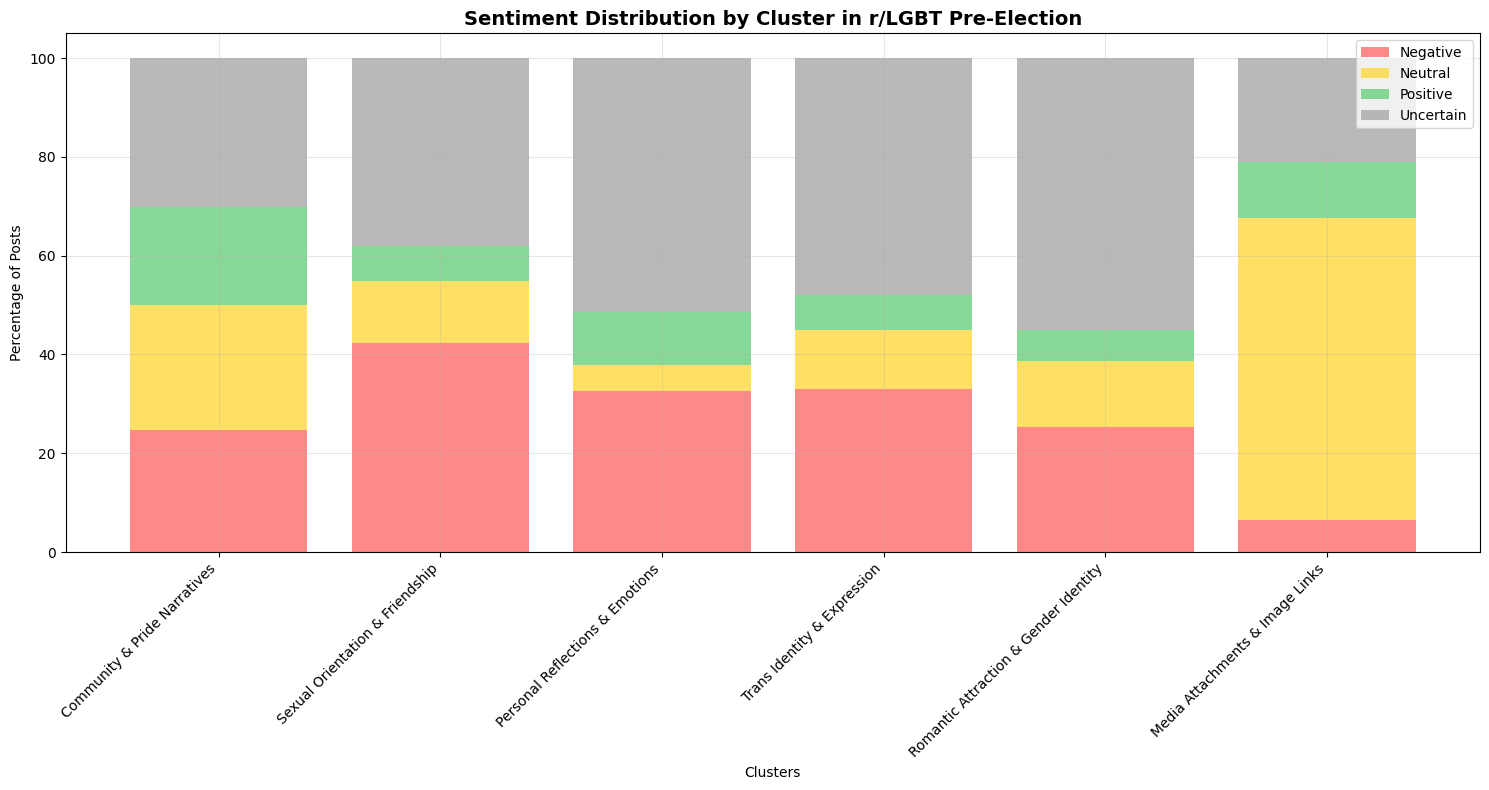

📊 Saved cluster sentiment distribution: /content/results/LGBT_clustered_before_cluster_sentiment_distribution.png

🎨 Creating plot for: feminsim_clustered_texts_before_with_sentiment.csv
📋 Cluster summary for feminsim_clustered_texts_before_with_sentiment.csv:
  Personal Views & Identity: 517 posts
    Neg: 50.3%, Neu: 13.7%, Pos: 7.0%, Unc: 29.0%
  Gendered Emotion & Reflection: 333 posts
    Neg: 58.3%, Neu: 6.6%, Pos: 1.5%, Unc: 33.6%
  Feminist Theory & Resources: 104 posts
    Neg: 5.8%, Neu: 19.2%, Pos: 29.8%, Unc: 45.2%
  Link-heavy or External Content: 124 posts
    Neg: 21.8%, Neu: 37.9%, Pos: 14.5%, Unc: 25.8%
  Political Discussion: 80 posts
    Neg: 53.8%, Neu: 16.2%, Pos: 3.8%, Unc: 26.2%


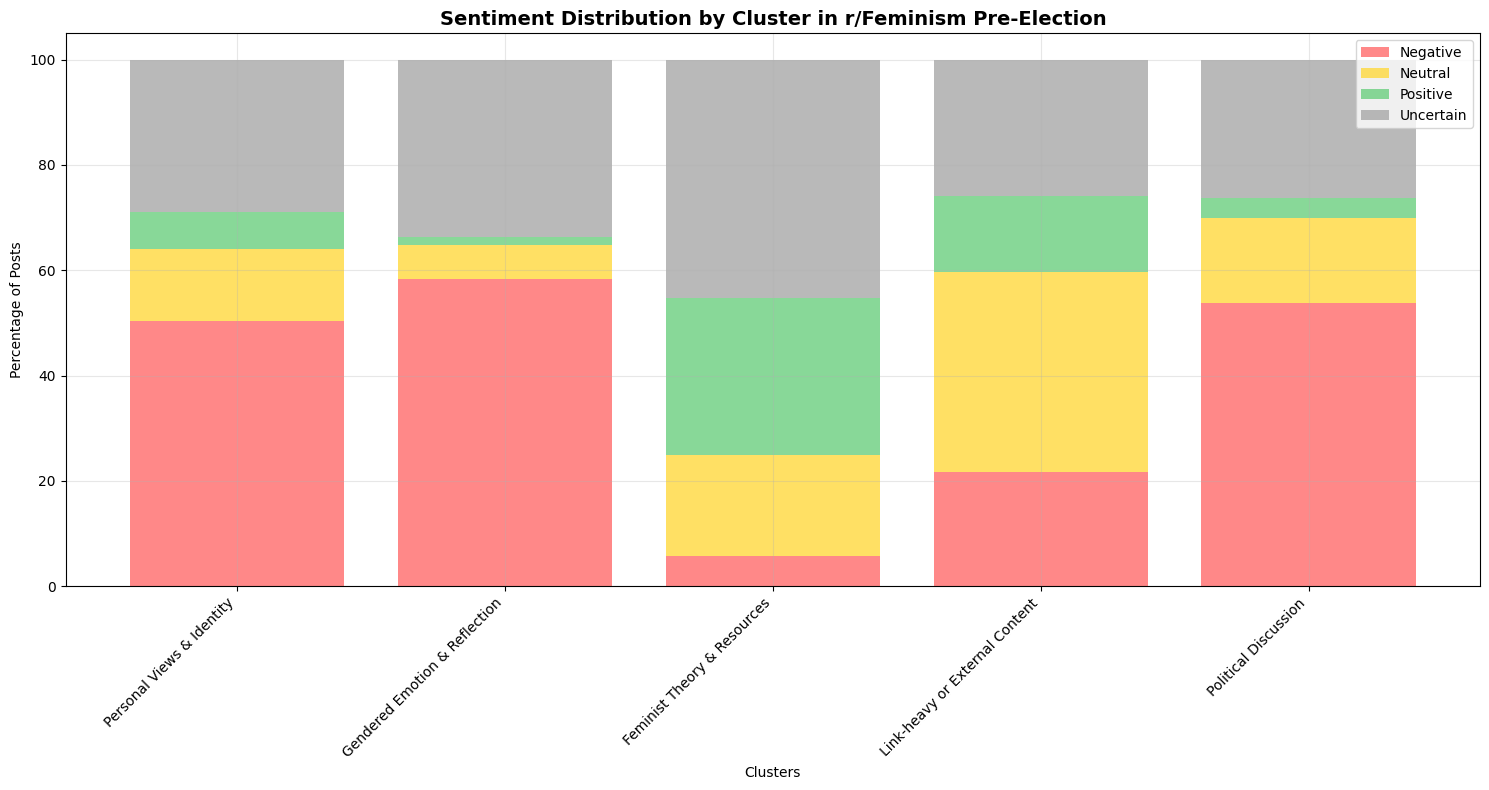

📊 Saved cluster sentiment distribution: /content/results/feminsim_clustered_texts_before_cluster_sentiment_distribution.png

🎨 Creating plot for: feminism_clustered_texts_after_with_sentiment.csv
📋 Cluster summary for feminism_clustered_texts_after_with_sentiment.csv:
  Gendered Emotion & Reflection: 638 posts
    Neg: 60.3%, Neu: 6.0%, Pos: 1.7%, Unc: 32.0%
  Personal Views & Identity: 1002 posts
    Neg: 42.9%, Neu: 14.3%, Pos: 9.2%, Unc: 33.6%
  Political Discussion: 318 posts
    Neg: 50.0%, Neu: 10.1%, Pos: 4.7%, Unc: 35.2%
  Link-heavy or External Content: 194 posts
    Neg: 21.1%, Neu: 39.7%, Pos: 12.9%, Unc: 26.3%
  Feminist Theory & Resources: 212 posts
    Neg: 11.3%, Neu: 21.7%, Pos: 36.8%, Unc: 30.2%


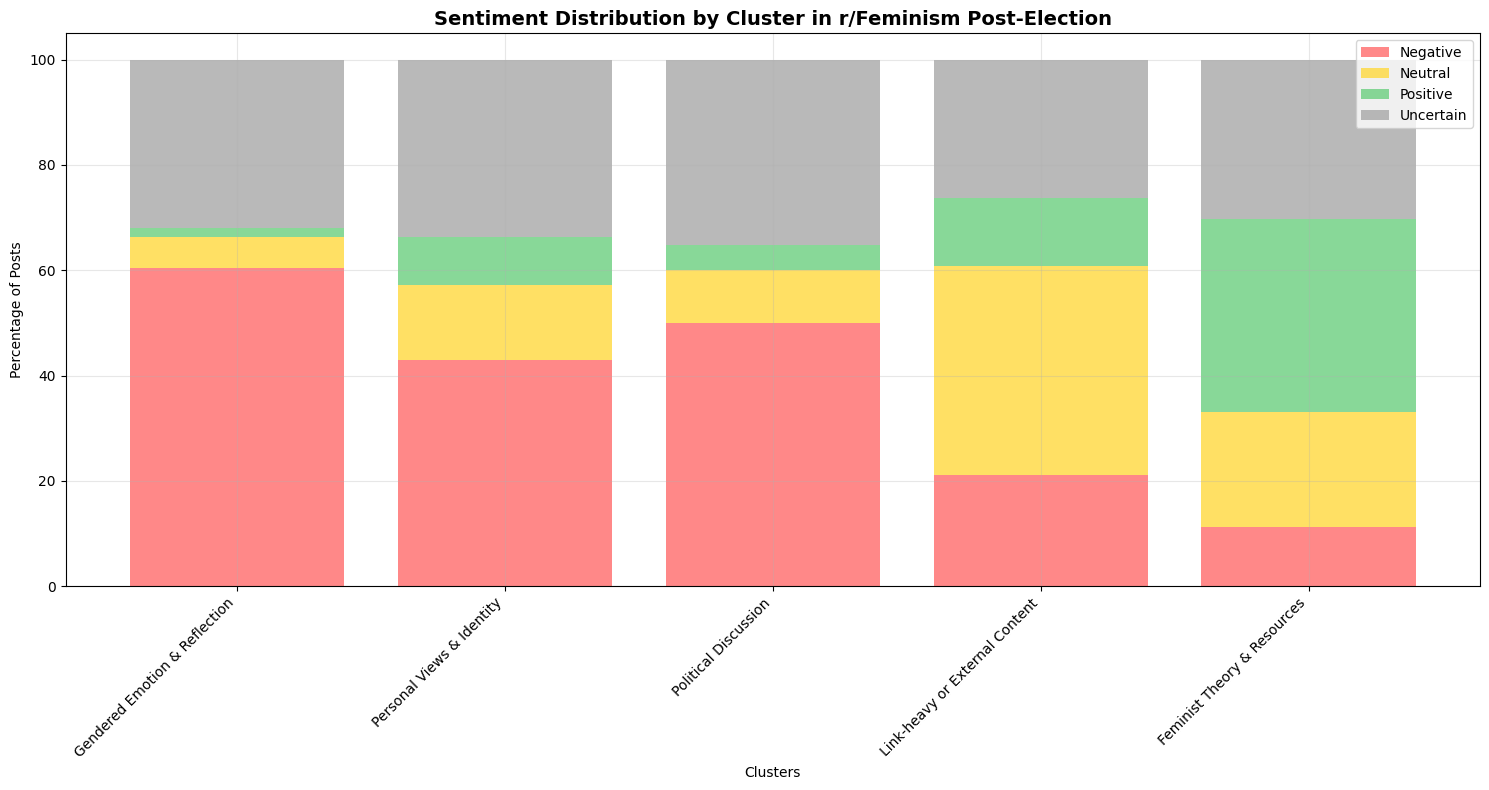

📊 Saved cluster sentiment distribution: /content/results/feminism_clustered_texts_after_cluster_sentiment_distribution.png

🎨 Creating plot for: LGBT_clustered_after_with_sentiment.csv
📋 Cluster summary for LGBT_clustered_after_with_sentiment.csv:
  Trans Identity & Expression: 2030 posts
    Neg: 33.3%, Neu: 11.9%, Pos: 7.2%, Unc: 47.6%
  Community & Pride Narratives: 9852 posts
    Neg: 27.3%, Neu: 22.6%, Pos: 19.1%, Unc: 31.0%
  Romantic Attraction & Gender Identity: 1163 posts
    Neg: 26.9%, Neu: 14.7%, Pos: 5.8%, Unc: 52.5%
  Personal Reflections & Emotions: 3738 posts
    Neg: 33.7%, Neu: 5.5%, Pos: 12.0%, Unc: 48.8%
  Sexual Orientation & Friendship: 1161 posts
    Neg: 45.1%, Neu: 11.9%, Pos: 6.8%, Unc: 36.2%
  Media Attachments & Image Links: 120 posts
    Neg: 8.3%, Neu: 59.2%, Pos: 15.0%, Unc: 17.5%


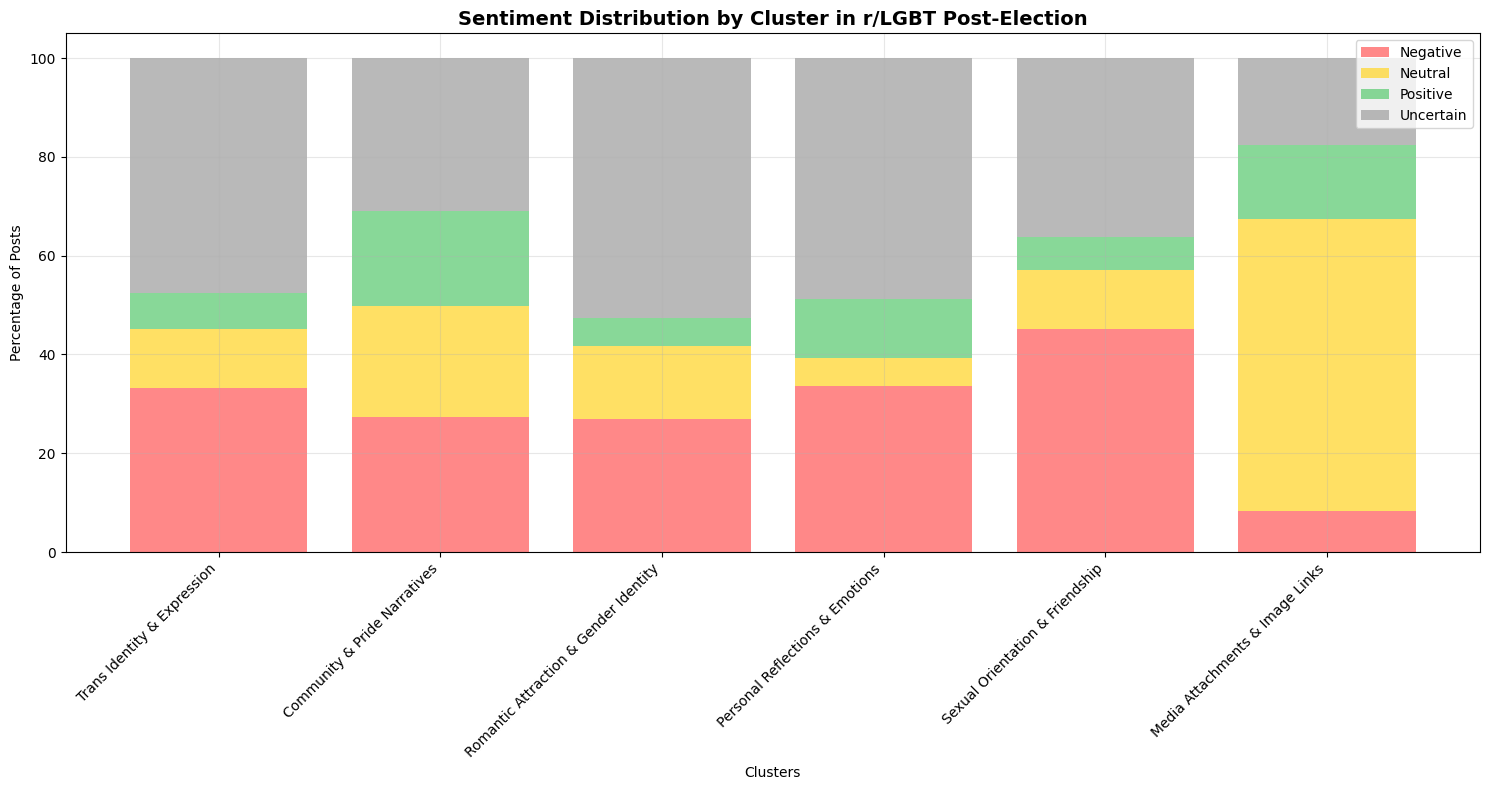

📊 Saved cluster sentiment distribution: /content/results/LGBT_clustered_after_cluster_sentiment_distribution.png

🎨 Creating plot for: MensRights_clustered_before_with_sentiment.csv
📋 Cluster summary for MensRights_clustered_before_with_sentiment.csv:
  Gender & Social Roles: 449 posts
    Neg: 60.8%, Neu: 9.4%, Pos: 2.4%, Unc: 27.4%
  Gender Issues & Male Victimhood: 754 posts
    Neg: 45.4%, Neu: 19.6%, Pos: 5.7%, Unc: 29.3%
  Masculinity & Identity: 519 posts
    Neg: 65.5%, Neu: 7.7%, Pos: 0.2%, Unc: 26.6%
  Personal Reflections & Emotions: 357 posts
    Neg: 55.5%, Neu: 5.6%, Pos: 5.0%, Unc: 33.9%
  External Content & News Links: 276 posts
    Neg: 35.9%, Neu: 34.4%, Pos: 2.5%, Unc: 27.2%
  Media & Link Embeds: 65 posts
    Neg: 10.8%, Neu: 84.6%, Pos: 1.5%, Unc: 3.1%


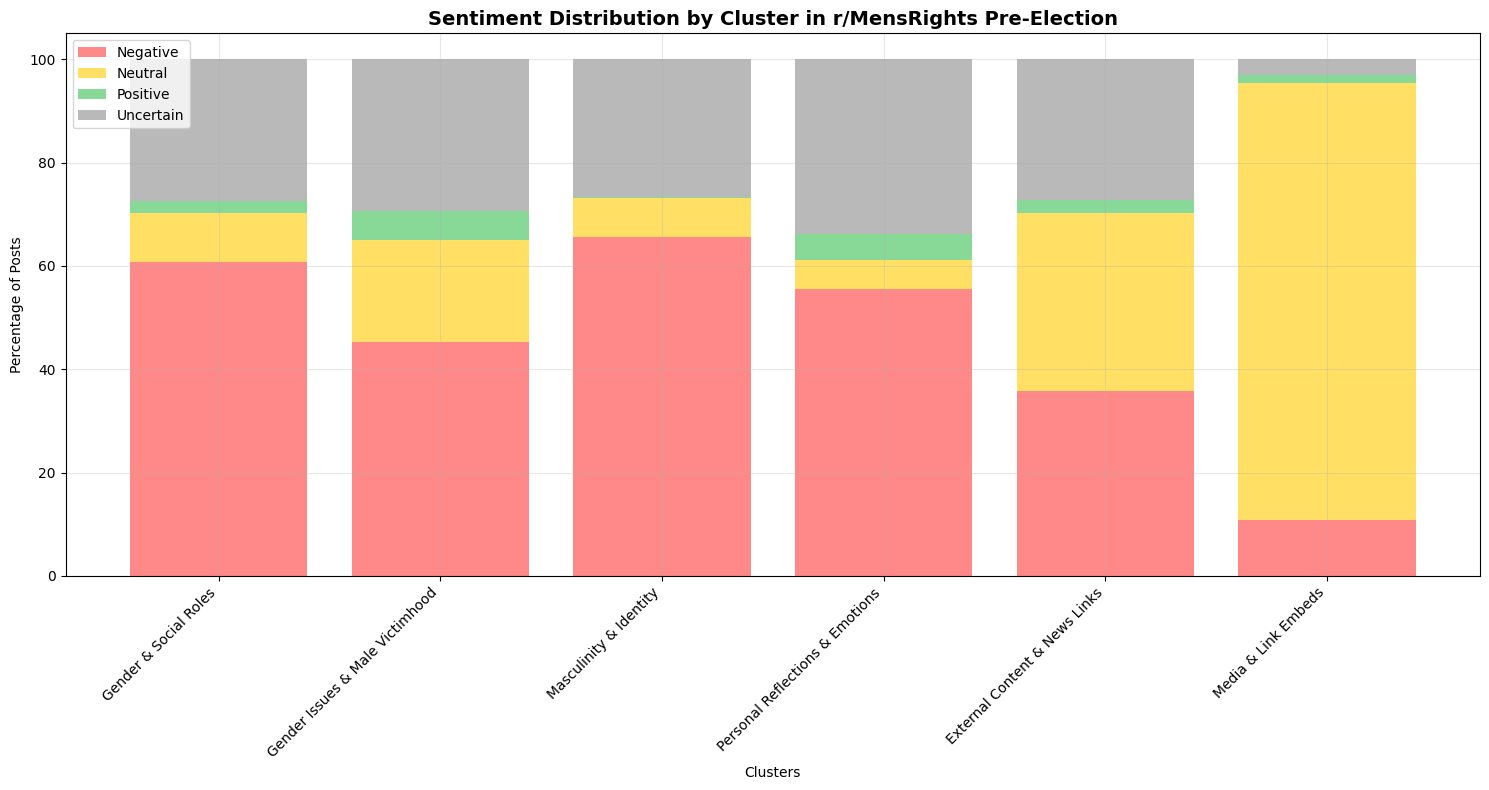

📊 Saved cluster sentiment distribution: /content/results/MensRights_clustered_before_cluster_sentiment_distribution.png

🎉 Generated 6 visualization plots!

📋 Summary Statistics Table:
Dataset              Cluster Name                   Posts    Neg%   Neu%   Pos%   Unc%  
MensRights_after     Masculinity & Identity         597      61.6   8.5    1.2    28.6  
MensRights_after     Personal Reflections & Emotions 374      56.7   5.6    4.3    33.4  
MensRights_after     Gender Issues & Male Victimhood 965      40.6   20.6   6.3    32.4  
MensRights_after     Gender & Social Roles          487      62.0   8.4    2.7    26.9  
MensRights_after     Media & Link Embeds            47       27.7   48.9   4.3    19.1  
MensRights_after     External Content & News Links  233      33.0   33.5   7.7    25.8  
LGBT_before          Community & Pride Narratives   9707     24.7   25.2   19.9   30.1  
LGBT_before          Sexual Orientation & Friendship 1457     42.3   12.6   7.1    38.0  
LGBT_before

In [15]:

import pandas as pd
import matplotlib.pyplot as plt
import os
from google.colab import files as colab_files

def calculate_cluster_sentiment_stats(df):
    """Calculate sentiment percentages by cluster"""
    cluster_stats = []

    for cluster_name in df['cluster_name'].unique():
        cluster_data = df[df['cluster_name'] == cluster_name]
        total_posts = len(cluster_data)

        if total_posts > 0:
            sentiment_counts = cluster_data['sentiment'].value_counts()

            negative_count = sentiment_counts.get('Negative', 0)
            neutral_count = sentiment_counts.get('Neutral', 0)
            positive_count = sentiment_counts.get('Positive', 0)
            uncertain_count = sentiment_counts.get('Uncertain', 0)

            cluster_stats.append({
                'cluster_name': cluster_name,
                'total_posts': total_posts,
                'negative_count': negative_count,
                'neutral_count': neutral_count,
                'positive_count': positive_count,
                'uncertain_count': uncertain_count,
                'negative_pct': (negative_count / total_posts) * 100,
                'neutral_pct': (neutral_count / total_posts) * 100,
                'positive_pct': (positive_count / total_posts) * 100,
                'uncertain_pct': (uncertain_count / total_posts) * 100
            })

    return pd.DataFrame(cluster_stats)

def plot_cluster_sentiment_comparison(cluster_df, filename, output_dir="/content/results"):
    """Create sentiment distribution plots by cluster"""
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(15, 8))
    clusters = cluster_df['cluster_name']

    # Calculate bottoms for stacked bar chart
    bottom_neutral = cluster_df['negative_pct']
    bottom_positive = cluster_df['negative_pct'] + cluster_df['neutral_pct']
    bottom_uncertain = cluster_df['negative_pct'] + cluster_df['neutral_pct'] + cluster_df['positive_pct']

    # Create stacked bars
    plt.bar(clusters, cluster_df['negative_pct'], label='Negative', color='#ff6b6b', alpha=0.8)
    plt.bar(clusters, cluster_df['neutral_pct'], bottom=bottom_neutral, label='Neutral', color='#ffd93d', alpha=0.8)
    plt.bar(clusters, cluster_df['positive_pct'], bottom=bottom_positive, label='Positive', color='#6bcf7f', alpha=0.8)
    plt.bar(clusters, cluster_df['uncertain_pct'], bottom=bottom_uncertain, label='Uncertain', color='#a8a8a8', alpha=0.8)

    # Title mapping
    title_map = {
        "mensrights_clustered_before_with_sentiment.csv": "Sentiment Distribution by Cluster in r/MensRights Pre-Election",
        "mensrights_clustered_after_with_sentiment.csv": "Sentiment Distribution by Cluster in r/MensRights Post-Election",
        "feminism_clustered_texts_before_with_sentiment.csv": "Sentiment Distribution by Cluster in r/Feminism Pre-Election",
        "feminism_clustered_texts_after_with_sentiment.csv": "Sentiment Distribution by Cluster in r/Feminism Post-Election",
        "feminsim_clustered_texts_before_with_sentiment.csv": "Sentiment Distribution by Cluster in r/Feminism Pre-Election",
        "lgbt_clustered_before_with_sentiment.csv": "Sentiment Distribution by Cluster in r/LGBT Pre-Election",
        "lgbt_clustered_after_with_sentiment.csv": "Sentiment Distribution by Cluster in r/LGBT Post-Election"
    }

    plot_title = title_map.get(filename.lower(), f"Sentiment Distribution by Cluster\n{filename}")
    plt.title(plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Clusters')
    plt.ylabel('Percentage of Posts')
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    plot_path = os.path.join(output_dir, filename.replace("_with_sentiment.csv", "_cluster_sentiment_distribution.png"))
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display in Colab
    plt.close()
    print(f"📊 Saved cluster sentiment distribution: {plot_path}")
    return plot_path

def create_summary_statistics_table(all_cluster_stats, output_dir="/content/results"):
    """Create a comprehensive summary statistics table for all files"""
    summary_rows = []

    for filename, cluster_stats in all_cluster_stats.items():
        # Extract dataset info from filename
        dataset_name = filename.replace("_with_sentiment.csv", "").replace("_clustered_texts", "").replace("_clustered", "")

        for _, row in cluster_stats.iterrows():
            summary_rows.append({
                'Dataset': dataset_name,
                'Filename': filename,
                'Cluster_Name': row['cluster_name'],
                'Total_Posts': row['total_posts'],
                'Negative_Count': row['negative_count'],
                'Neutral_Count': row['neutral_count'],
                'Positive_Count': row['positive_count'],
                'Uncertain_Count': row['uncertain_count'],
                'Negative_Pct': round(row['negative_pct'], 1),
                'Neutral_Pct': round(row['neutral_pct'], 1),
                'Positive_Pct': round(row['positive_pct'], 1),
                'Uncertain_Pct': round(row['uncertain_pct'], 1)
            })

    # Create DataFrame and save
    summary_df = pd.DataFrame(summary_rows)
    summary_path = os.path.join(output_dir, "cluster_sentiment_summary_statistics.csv")
    summary_df.to_csv(summary_path, index=False)

    print(f"\n📋 Summary Statistics Table:")
    print("=" * 120)
    print(f"{'Dataset':<20} {'Cluster Name':<30} {'Posts':<8} {'Neg%':<6} {'Neu%':<6} {'Pos%':<6} {'Unc%':<6}")
    print("=" * 120)

    for _, row in summary_df.iterrows():
        print(f"{row['Dataset']:<20} {row['Cluster_Name']:<30} {row['Total_Posts']:<8} "
              f"{row['Negative_Pct']:<6} {row['Neutral_Pct']:<6} {row['Positive_Pct']:<6} {row['Uncertain_Pct']:<6}")

    print("=" * 120)
    print(f"💾 Saved summary statistics: {summary_path}")
    return summary_path

# Generate visualizations for all processed files
results_dir = "/content/results"
sentiment_files = [f for f in os.listdir(results_dir) if f.endswith('_with_sentiment.csv')]

print(f"📊 Generating visualizations for {len(sentiment_files)} files...")

plot_files = []
all_cluster_stats = {}  # Store all cluster statistics for summary table

for filename in sentiment_files:
    print(f"\n🎨 Creating plot for: {filename}")

    try:
        # Load the processed data
        file_path = os.path.join(results_dir, filename)
        df = pd.read_csv(file_path)

        # Check if required columns exist
        if 'cluster_name' not in df.columns or 'sentiment' not in df.columns:
            print(f"⚠️ Missing required columns in {filename}")
            print(f"Available columns: {list(df.columns)}")
            continue

        # Calculate cluster sentiment statistics
        cluster_stats = calculate_cluster_sentiment_stats(df)

        if len(cluster_stats) == 0:
            print(f"⚠️ No cluster data found in {filename}")
            continue

        # Store cluster stats for summary table
        all_cluster_stats[filename] = cluster_stats

        print(f"📋 Cluster summary for {filename}:")
        for _, row in cluster_stats.iterrows():
            print(f"  {row['cluster_name']}: {row['total_posts']} posts")
            print(f"    Neg: {row['negative_pct']:.1f}%, Neu: {row['neutral_pct']:.1f}%, Pos: {row['positive_pct']:.1f}%, Unc: {row['uncertain_pct']:.1f}%")

        # Generate the plot
        plot_path = plot_cluster_sentiment_comparison(cluster_stats, filename)
        plot_files.append(plot_path)

    except Exception as e:
        print(f"❌ Error processing {filename}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n🎉 Generated {len(plot_files)} visualization plots!")

# Generate summary statistics table
if all_cluster_stats:
    summary_path = create_summary_statistics_table(all_cluster_stats)
    plot_files.append(summary_path)  # Add summary file to download list

Download files

In [16]:

# Download the plot files and summary table
print("\n📥 Downloading files:")
for file_path in plot_files:
    if os.path.exists(file_path):
        colab_files.download(file_path)
        print(f"Downloaded: {os.path.basename(file_path)}")
else:
    print("⚠️ No files to download")


📥 Downloading files:


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: MensRights_clustered_after_cluster_sentiment_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: LGBT_clustered_before_cluster_sentiment_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: feminsim_clustered_texts_before_cluster_sentiment_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: feminism_clustered_texts_after_cluster_sentiment_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: LGBT_clustered_after_cluster_sentiment_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: MensRights_clustered_before_cluster_sentiment_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded: cluster_sentiment_summary_statistics.csv
⚠️ No files to download
